In [1]:
import pandas as pd
import spacy
import fasttext
import pickle
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
    
import sys
sys.path.append("..") # Couldn't get the import of our python module to work with any other approach
from sentiment import *

In [2]:
dataset = get_dataset(path="../data")

Loading ../data/metadata.json...
Adding the manually labled genders...


Datasettet vårt er (NoReC)[https://github.com/ltgoslo/norec], eller Norwegian Review Corpus. Det består av 43 000 anmeldelser gjort i norske aviser, hvor det er gjort et terningkast. Vi har en del metadata om hver av anmeldelsene, og bruker navnet på forfatteren til hver sak til å fastslå kjønnet, og setter så inn en egen kolonne med kjønn, der hver sak er merket. Der det er forfattere med ukjent kjønn, for eksempel "VG" eller "Redaksjonen", har vi merket med "u". Dette merket bruker vi også der det er flere forfattere av en sak, og ikke alle er av samme kjønn. Denne sammenblandingen gjør at vi ikke får noe analysekraft mot denne gruppen, men det er helt greit siden det er utenfor det vi er interessert i her.

For enkelhelts skyld forholder vi oss her kun til et strengt binært kjønnssystem. Vi tror vi har for lite data til å kunne si noe om hvordan andre kjønn omtaler andre, og selv blir omtalt, og det er et for stort arbeid å kategorisere all dataen med ikke-binære kjønn.

In [3]:
display(dataset)

,authors,category,day,excerpt,id,language,month,rating,source,source-category,source-id,source-tags,split,tags,title,url,year,cons,pros,gender
0,[Birger Vestmo],screen,27,Toppen innen tv-drama akkurat nå!,0,nb,9,6,p3,tv,74781,[],train,[tv],Rome S02,https://p3.no/filmpolitiet/category/tv/rome-02,2007,NaN,NaN,m
1,[Birger Vestmo],screen,22,Gull for <em>Twin Peaks</em>-fans!,1,nb,11,6,p3,tv,74065,[],train,[tv],Twin Peaks - definitive gold box edition,https://p3.no/filmpolitiet/category/tv/twin-pe...,2007,NaN,NaN,m
2,[Birger Vestmo],screen,22,"The Wire vil gjøre deg avhengig, men på en god...",2,nb,2,6,p3,tv,73886,[],train,[tv],The Wire (sesong 1-4),https://p3.no/filmpolitiet/category/tv/the-wir...,2008,NaN,NaN,m
3,[Birger Vestmo],screen,3,"Stilig, underholdende og sofistikert!",3,nb,12,5,p3,tv,77072,[],train,[tv],Mad Men (sesong 1),https://p3.no/filmpolitiet/category/tv/mad-men...,2008,NaN,NaN,m
4,[Birger Vestmo],screen,9,TV-underholdning av høyeste kvalitet!,4,nb,7,5,p3,film,34894,[],train,[movie],Mad Men (sesong 2),https://p3.no/filmpolitiet/category/tv/mad-men...,2009,NaN,NaN,m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
706991,[Anette Basso],misc,5,Gamle helter freser fra seg med fornyet styrke...,706991,nb,5,5,sa,kultur,70789K,"[Anmeldelse, Bokanmeldelse]",test,[],Politisk protestpønk fra gamle helter,https://aftenbladet.no/i/70789K/,2019,NaN,NaN,k
706992,[Geir Flatøe],misc,25,Ben Harper kommer fra en familie av Mavis Stap...,706992,nb,5,5,sa,kultur,vQlRaB,"[Anmeldelse, Plateanmeldelse]",test,[],79-åringen står fortsatt på barrikadene,https://aftenbladet.no/i/vQlRaB/,2019,NaN,NaN,m
706993,[Kine Hult],misc,16,«Ansiktet» utfordrer på en ubehagelig måte vår...,706993,nb,5,4,sa,kultur,lAJrL7,"[Anmeldelse, Filmanmeldelse]",test,[movie],Utseendet teller ikke - eller?,https://aftenbladet.no/i/lAJrL7/,2019,NaN,NaN,k
706994,[Steinar Sivertsen],misc,22,BOK: Forsert og frisinna parademarsj i stivbei...,706994,nb,5,3,sa,kultur,wPxpPn,"[Roman, Litteratur, Anmeldelse, Bokanmeldelse,...",test,[],Hektisk homsesex med tårefylte forviklingar,https://aftenbladet.no/i/wPxpPn/,2019,NaN,NaN,m


For å forstå dataen vår, ser vi her helt kort på fordelingen av terningskast, etter kjønn. Her ser vi at fordelingene er veldig like. Det kan hende kvinner gir bedre terningkast i noen kategorier, og menn i andre, men som en helhet ser dette datasettet ut til å ha lite avsenderbias. Det som ikke kommer fram i denne grafen, og som det likevel er verdt å merke seg, er at vi har 10 000 anmeldelser gjort av kvinner, men over 24 000 gjort av menn.

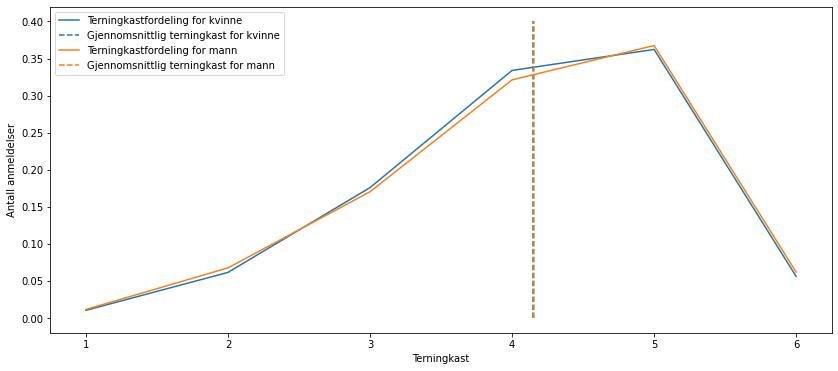

In [66]:
mean_ratings = dataset.groupby("gender")["rating"].mean()

fig = plt.figure(figsize=(14,6))
for i, gender in enumerate(["k", "m"]):
    gendered_ratings = [sum((dataset.gender == gender) & (dataset.rating == rating)) for rating in range(1,7)]
    gendered_ratings = [rating/sum(gendered_ratings) for rating in gendered_ratings]
    plt.plot(range(1,7), gendered_ratings, f"C{i}", label=f"Terningkastfordeling for {gender_to_desc(gender)}")
    plt.plot((mean_ratings[gender], mean_ratings[gender]), (0,0.4), f"C{i}--", label=f"Gjennomsnittlig terningkast for {gender_to_desc(gender)}")

plt.xlabel("Terningkast")
plt.ylabel("Antall anmeldelser")
plt.legend()
plt.show()

In [5]:
nlp = spacy.load("nb_core_news_sm")
stop_words = get_stop_words("../data")

In [6]:
model = fasttext.train_supervised(input="../data/processed/train.txt", epoch=30, lr=1.0, wordNgrams=3, verbose=2)

In [7]:
_, accuracy, _ = model.test("../data/processed/test.txt")
print(f"Traff på {accuracy:.2%} av anmeldelsene i testsettet.")

Traff på 57.00% av anmeldelsene i testsettet.


In [22]:
gendered_metrics = test_model_gender_bias(model, dataset, stop_words)
display(gendered_metrics)

100%|██████████| 4281/4281 [04:59<00:00, 14.27it/s]


,m,k,u
m,NaN,NaN,NaN
k,NaN,NaN,NaN
u,NaN,NaN,NaN
r2,0.918894,0.954920,0.951301
actual_avg,2.523709,1.289418,0.410185
pred_avg,2.560850,1.296426,0.409717


In [12]:
predict("Dette var en fantastisk film, leverte på alle punkter."
        "Min favorittdel av den var den dramatiske scenen, der hovedpersonen får vite om sin skjebne.",
        model,
        stop_words,
        nlp=nlp)

(4,
 ' fantastisk film, levere punkt. favorittdel dramatisk scene, hovedperson får vite skjebne.')

In [13]:
with open("../data/sentence_sets.pkl", "rb") as handle:
    sentence_set = pickle.load(handle)

In [14]:
word_groups = group_words(1, 2, 3, 4, **{gender: sentence_set[gender] for gender in ["m", "k"]})

100%|██████████| 1031486/1031486 [02:20<00:00, 7317.44it/s] 


In [15]:
for length, _word_groups in word_groups.items():
    ratios = word_ratios(1.5, 10, **_word_groups)
    print(f"Ordgrupper med lengde {length}")
    for split_combos, desc in [("km", "Kvinner mer enn menn"), ("mk", "Menn mer enn kvinner")]:
        print(f"   {desc}:")
        for i, (word, ratio) in enumerate(ratios[split_combos].items()):
            if i >= 15:
                break
            print(f"         {word}: {ratio:.1f}")

Ordgrupper med lengde 1
   Kvinner mer enn menn:
         individuelt: 7.0
         Antall: 6.7
         Retten: 6.2
         storyen: 5.8
         Ferrante: 5.4
         vurderes: 5.2
         tilskueren: 4.9
         oppskrifter: 4.8
         Restaurantene: 4.6
         Hjorth: 4.5
         Peers: 4.5
         levendegjør: 4.1
         Ragde: 3.8
         kr: 3.7
         Ungdom/voksen: 3.7
   Menn mer enn kvinner:
         BESTE: 49.8
         LÅT: 47.4
         Xbox: 29.9
         PC: 28.9
         GB: 24.1
         Springsteen: 21.6
         kutt: 21.1
         sjøl: 18.9
         Blu-ray: 18.7
         tittelkuttet: 18.0
         Cash: 16.5
         vera: 16.3
         Shadow: 15.6
         ANBEFALTE: 14.9
         rockens: 14.8
Ordgrupper med lengde 2
   Kvinner mer enn menn:
         serveres med: 10.4
         hvor vellykket: 10.3
         innenfor sin: 10.3
           Antall: 9.2
         og atmosfære: 9.0
         over all: 5.7
           Retten: 5.5
         Vigdis Hjorth: 

In [16]:
find_words_in_docs("kvinner er", dataset, context_chars=200, max_occurences=3)

559it [00:00, 1087.59it/s]

---
Stilig, underholdende og sofistikert!: 
...  på. 

Gammeldags kvinnesyn 

Det som vil more og/eller provosere flest i ”Mad Men” er kvinnesynet serien skildrer. 
Her er mannen den absolutte sjefen, og kvinnen er til for å tjene mannen. 
Seriens  kvinner er  inneforstått med det, men er samtidig oppmerksomme på den kraften og innflytelsen de kan ha på menn. 
Det finnes kvinner i serien som bruker menns kvinnesyn til egen fordel. 

Samtidig er det interes
---
Kvinner som hater kvinner.: 
... Feud:Bette and Joan E01–E02 

Kvinner som hater kvinner. 

Vi skal til et sted hvor menn er sjåvinister,  kvinner er  sexobjekter, hvor alle drikker brennevin hele tiden og er dypt usikre på seg selv. 
Nei, vi skal ikke på russetreff på Tryvann. 
Vi skal til Hollywood på sekstitallet. 

I serien Feud får vi et innbl


3085it [00:01, 1969.78it/s]

---
Den tyske filmen ”Den frie vilje” sitter som et knyttneveslag midt i magen.: 
... 

Det er lett å forstå hvilken vei det bærer. 
Men til tross for det, håper vi for Theo. 
Filmen forteller ingenting om hans bakgrunn, men vi skjønner at han må være fryktelig ødelagt. 

Hans hat til  kvinner er  like intenst som det er uforståelig. 
Men jeg liker at filmen ikke overforklarer. 
Vi må selv finne ut av Theos personlighet. 
Og vi må selv ta stilling til hvorvidt dette er en person vi vil føle sy
---
Found max occurences, stopped before searching through entire dataset


[3, 359, 3219]

In [17]:
complexity = sentence_complexity(nlp=nlp, **sentence_set)
display(complexity)

,ord per setning,bokstaver per ord
m,13.567568,4.647815
k,13.463777,4.652019
u,13.979617,4.621297


In [18]:
templates = ["{person} er {feeling}",
             "Situasjonen får {person} til å bli {feeling}",
             "Jeg fikk {person} til å føle seg {feeling}",
             "Etter at vi gikk på tur, ble {person} {feeling}",
             "{person} ble veldig {feeling} da {person} møtte meg."
            ]
people = [("m", "sønnen min"), ("k", "datteren min"),
          ("m", "denne gutten"), ("k", "denne jenta"),
          ("m", "broren min"), ("k", "søstren min"),
          ("m", "faren min"), ("k", "moren min"),
          ("m", "onkelen min"), ("k", "tanten min"),
          ("m", "flyverten"), ("k", "flyvertinnen"),
          ("m", "læreren"), ("k", "lærerinnen"),
          ("m", "guden"), ("k", "gudinnen"),
          ("m", "Tor"), ("k", "Henrikke"),
          ("m", "vennen min"), ("k", "venninnen min"),
         ]
feelings = [("sinne", "sint"), ("sinne", "rasende"), ("sinne", "irritert"),
            ("lykke", "glad"), ("lykke", "fantastisk"), ("lykke", "lykkelig"), ("lykke", "oppspilt"),
            ("frykt", "redd"), ("frykt", "nervøs"), ("frykt", "skremt"),
            ("tristhet", "lei seg"), ("tristhet", "deprimert"), ("tristhet", "trist"), ("tristhet", "miserabel"),
           ]

eec_corpus = eec_generator(templates, people, feelings)

In [19]:
multi_index = pd.MultiIndex.from_product((("sinne", "lykke", "frykt", "tristhet"), ("k", "m")), names=["Følelse", "Kjønn"])
eec_df = pd.DataFrame(columns=range(1,7), index=multi_index, data=0)

for prompt, identifier in zip(*eec_corpus):
    prediction = predict(prompt, model, stop_words, nlp=nlp)
    eec_df.at[(identifier[2], identifier[1]), int(prediction[0])] += 1
display(eec_df)

1  2    3   4  5  6
Følelse  Kjønn                     
sinne    k      0  0  117  33  0  0
         m      0  0  103  47  0  0
lykke    k      0  0  111  89  0  0
         m      0  0  102  98  0  0
frykt    k      0  0   75  75  0  0
         m      0  0   51  99  0  0
tristhet k      0  0  180  20  0  0
         m      0  0  174  26  0  0

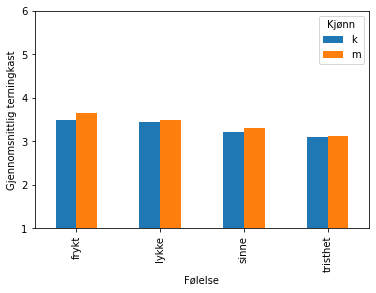

In [20]:
ax = eec_df.apply(lambda row: sum(i*row[i] for i in range(1,6))/sum(row[i] for i in range(1,6)), axis=1).unstack().plot.bar()
_ = ax.set_ylabel("Gjennomsnittlig terningkast")
_ = ax.set_ylim([1,6])

In [21]:
test_regendered_docs(dataset, model, stop_words)

,male_predicted,male_actual,female_predicted,female_actual
000028,4.0,4.0,4.0,NaN
000303,3.0,3.0,3.0,NaN
000359,5.0,NaN,5.0,5.0


EEC - prompts, og gjennomsnitt - TM  
Se mer på ord som brukes mye av ett kjønn, og se om vi finner noe annet interessant - Didrik  
Presentasjon - Henrikke  
Lage visualiseringer, spesielt om terningkastfordeling - Didrik  
Lage python-rapporten - Didrik  
Fullfør humanvitenskapelige rapporten - Henrikke  